# Dissociation dynamics of H$_2^+$ in XUV and IR laser fields
by Tobias Becher, Lukas Blecher

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
import time
from matplotlib import animation
from IPython.display import HTML
import scipy.constants as const
import scipy.fftpack as ft
import pandas as pd

In [2]:
#load given data
xd,D=np.loadtxt('data/dipole_coupling.dat',unpack=True)
_,Vg=np.loadtxt('data/H2p_pot_gerade.dat',unpack=True)
_,Vu=np.loadtxt('data/H2p_pot_ungerade.dat',unpack=True)
_,Psi0=np.loadtxt('data/H2nuclwf.dat',unpack=True)
#normalize Psi0
Psi0=Psi0/LA.norm(Psi0)

## 1. Vibrational eigenstates in the H$_2^+$ ground state potential

In [3]:
#atomic units
nm=1e-9/5.2917721092e-11
fs=1e-15/2.418884326505e-17
epsilon0=1/(4*np.pi*1.054571726e-34)
c=137

In [4]:
#reduced mass
m=938.28/(0.511*2)
L,npoints = 30,600
dx=L/(npoints)
xvals = np.linspace(dx,L,npoints)
V=Vg[:npoints]
#build Hamiltonian
HDiag = np.ones(npoints)/dx**2/2/m
Hofdiag = -0.5*np.ones(npoints-1)/dx**2/2/m
Hsparse = sp.diags([Hofdiag, HDiag + V, Hofdiag],[-1,0,1])
e, v = sLA.eigsh(Hsparse, k=25, which='SA')

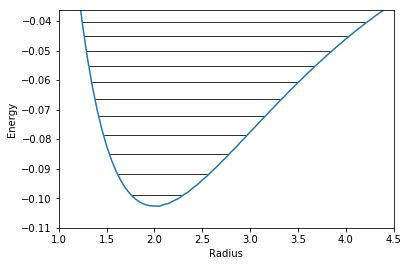

In [5]:
#plot vibrational eigenstates
plt.ylim(-.11,-.03640998)
plt.xlim(1,4.5)
for j in e:
    plt.plot(xvals,j*np.ones(npoints),lw=.8,c='black',zorder=0)
    
plt.plot(xvals,V)
plt.fill_between(xvals,-1,V,color='white')
#plt.title('Vibrational eigenstates in atomic units')
plt.xlabel('Radius')
plt.ylabel('Energy')
plt.savefig('report/figures/vibEigenstates.eps')

In [6]:
df=pd.DataFrame(np.transpose([e,e*4.35974417e-18/1.602176565e-19]),columns=['eigenenergies','eV'])
df.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
eigenenergies,-0.098974,-0.091811,-0.084977,-0.078439,-0.072198,-0.066243,-0.060562,-0.055149,-0.049999,-0.045103,...,-0.020885,-0.017701,-0.014748,-0.012046,-0.009592,-0.007397,-0.005465,-0.003809,-0.002440,-0.001368
eV,-2.693208,-2.498296,-2.312333,-2.134430,-1.964603,-1.802554,-1.647989,-1.500673,-1.360536,-1.227319,...,-0.568307,-0.481656,-0.401302,-0.327785,-0.261007,-0.201281,-0.148707,-0.103661,-0.066396,-0.037237


## 2. Simulation of the wave packet propagation without the IR laser field

In [7]:
#write a class for a state and potential to perform a split step fourier method on
class state:
    def __init__(self,initial,V,npoints,L,m=1):
        self.ini,self.Psi,self.V,self.V0,self.t,self.N,self.L,self.m=initial,initial,V,V,0,npoints,L,m

    def evolution(self,tsteps,dt):
        dx = self.L/self.N
        xvals = np.linspace(-self.L/2,self.L/2,self.N,endpoint=False)
        kvals = 2*np.pi*np.fft.fftfreq(self.N,d=dx)
        # propagate the wave packet
        tvec = np.linspace(0,tsteps*dt,tsteps+1) # will have length tsteps+1
        # container for storing the result
        psit = 0j*np.zeros((tsteps+1,self.N))
        # store initial value
        psit[0] = self.ini

        for i in range(tsteps):
            # apply potential
            psi = np.exp(-1j*dt*self.V)*psit[i]
            # go to Fourier space
            psi = np.fft.fft(psi)
            # apply kinetic part
            psi = np.exp(-1j*dt*kvals**2/(2*self.m))*psi
            # go back to real space
            psi=np.fft.ifft(psi)
            # store the result
            psit[i+1] = psi
        self.psit=psit
    def get(self):
        return self.Psi
    def reset(self):
        self.Psi=self.ini
        self.t=0
        self.V=self.V0

In [8]:
#calculate kinetic part
dx= np.mean(np.diff(xvals))
k = 2*np.pi*np.fft.fftfreq(xvals.size,d = dx)
dk = np.diff(k).mean()
Ekin = k**2/(2*m)
#initialize it
Psi=state(Psi0[:npoints],Vg[:npoints],npoints,L,m)

In [9]:
dt,tsteps=.5,2000
Psi.reset()
Psi.evolution(tsteps,dt)

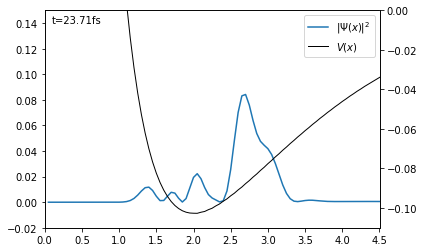

In [10]:
fig, ax1 = plt.subplots()
# add axis specifications
line, = ax1.plot([],[],label='$|\Psi(x)|^2$')
plt.ylim(-.02,.15)
plt.xlim(0,4.5)
ax2=ax1.twinx()
plt.ylim(-.11,0)
linePot, = ax2.plot(xvals,V,color='black',lw=1,label='$V(x)$')
plt.legend()
plt.xlabel('x')
#plt.ylabel('wave function')
#plt.title('Wave packet propagation without IR laser')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

def animate(t):
    print('%.1f%s'%(100*t/tsteps,'%'),end='\r')
    line.set_data(xvals,np.abs(Psi.psit[int(t)])**2)
    ax1.text(0.1,.14,'t=%.2ffs'%(dt*t/fs),ha='left',bbox=dict(facecolor='white', alpha=1 ,lw=0))
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,40), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)
#anim.save('propagation_without_IR-Laser.mp4')
HTML(anim.to_jshtml())

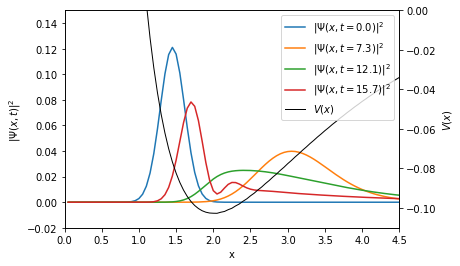

In [11]:
#stationary picture with time development for the report
stamps=np.array([0,.3,.5,.65])
times=np.array(stamps*tsteps,dtype=np.int)
fig, ax1 = plt.subplots()
# add axis specifications
for i in range(len(times)):
    ax1.plot(xvals,np.abs(Psi.psit[times[i]])**2,label='$|\Psi(x,t=%.1f)|^2$'%(times[i]*dt/fs))
plt.ylim(-.02,.15)
plt.xlim(0,4.5)
ax2=ax1.twinx()
plt.ylim(-.11,0)
linePot, = ax2.plot(xvals,V,color='black',lw=1,label='$V(x)$')
plt.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('$|\Psi(x,t)|^2$')
ax2.set_ylabel('$V(x)$')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,loc=1)
plt.savefig('report/figures/woIR.eps')

## 3. Simulation of the dynamics of the time-dependent system with two coupled energy surfaces, coupled by the time-dependent IR laser field.

In [12]:
theta=0

lam=760*nm
I0=5.1e16 #W/m^2
w=c/lam*2*np.pi
E0=np.sqrt(2*I0/8.854187817e-12/299792458)/5.14220652e11
E=E0*np.cos(theta)
sigfwhm=8.6*fs

tau=0

In [13]:
def E_t(t,tau,fwhm=sigfwhm,E=E,w=w):
     return E*np.cos(w*t)*np.exp(-(t-tau)**2/(2*(fwhm/(2*np.sqrt(2*np.log(2))))**2))

In [14]:
#new version of the class so it can handle the special situation 
class state:
    def __init__(self,initial1,initial2,Vg,Vu,D,Ekin,npoints,L,tau,m=1):
        #initial state
        self.ini1,self.ini2=initial1,initial2
        #current state that is updated after advancing in time
        self.Psi1,self.Psi2=initial1,initial2
        #storage of all states visited over time
        self.Psi1t,self.Psi2t=[initial1],[initial2]        
        #save parameters
        self.Ekin,self.Vg,self.Vu,self.D,self.t,self.N,self.L,self.m,self.tau=Ekin,Vg,Vu,D,0,npoints,L,m,tau
        
    def advance(self,dt):
        #first potential step
        Psi1 = np.exp(-1j*self.Vg*dt/2)*self.Psi1
        Psi2 = np.exp(-1j*self.Vu*dt/2)*self.Psi2
        
        #applying unitary matrices
        Psi1n = 1/np.sqrt(2)*(Psi1+Psi2)
        Psi2n = 1/np.sqrt(2)*(Psi1-Psi2)
        #time dependent potential step
        Psi1 = np.exp(-1j*dt*self.D*E_t(self.t+dt/2,self.tau))*Psi1n
        Psi2 = np.exp(1j*dt*self.D*E_t(self.t+dt/2,self.tau))*Psi2n
        #unitary again
        Psi1n = 1/np.sqrt(2)*(Psi1+Psi2)
        Psi2n = 1/np.sqrt(2)*(Psi1-Psi2)
        #final potential step
        Psi1 = np.exp(-1j*self.Vg*dt/2)*Psi1n
        Psi2 = np.exp(-1j*self.Vu*dt/2)*Psi2n
        
        Psi1 = np.fft.fft(Psi1)                    # Fourier transform
        Psi2 = np.fft.fft(Psi2)
        Psi1k = np.exp(-1j*self.Ekin*dt)*Psi1      # advance in Fourier space
        Psi2k = np.exp(-1j*self.Ekin*dt)*Psi2 
        self.Psi1 = np.fft.ifft(Psi1k)             # return to real space
        self.Psi2 = np.fft.ifft(Psi2k)
        self.Psi1t.append(self.Psi1)
        self.Psi2t.append(self.Psi2)
        self.t+=dt
        
    def get(self):
        return self.Psi1,self.Psi2
    
    def reset(self):
        self.Psi1=self.ini1
        self.Psi2=self.ini2
        self.Psi1t=self.Psi2t=[]
        self.t=0

In [15]:
#work out kinetic energy
x = xd[1:-1] #only linear part
dx= np.mean(np.diff(x))
k = 2*np.pi*ft.fftfreq(x.size,d = dx)
dk = np.diff(k).mean()
Ekin = k**2/(2*m)

In [16]:
#initialize the state
a,b=5,200
Psi=state(Psi0[a:b],np.zeros(b-a),Vg[a:b],Vu[a:b],D[1:-1],Ekin,b-a,tau,m)

In [17]:
#time evolution
dt,tsteps=1,3000
Psi.reset()
Psit1=[]
Psit2=[]
for t in np.arange(0,dt*tsteps,dt):
    Psi.advance(dt)
    Psi1,Psi2=Psi.get()
    Psit1.append(Psi1)
    Psit2.append(Psi2)

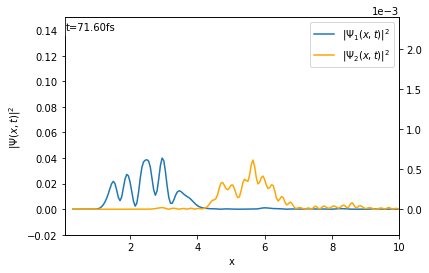

In [18]:
fig, ax = plt.subplots()
ax.set_xlim(( 0.05,10))
ax.set_ylim((-.02,.15))
ax.set_xlabel("x")
ax.set_ylabel("$|\Psi(x,t)|^2$")
line1, = ax.plot([],[],label="$|\Psi_1(x,t)|^2$")
ax2=ax.twinx()
ax2.set_ylim((-.02*0.0024/.15,0.0024))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
line2, = ax2.plot([],[],color='orange',zorder=0,label="$|\Psi_2(x,t)|^2$")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,loc=1)
def animate(t):
    print('%.1f%s'%(100*t/tsteps,'%'),end='\r')
    line1.set_data(x, np.abs(Psit1[t])**2)
    line2.set_data(x, np.abs(Psit2[t])**2)
    ax.text(0.1,.14,'t=%.2ffs'%(dt*t/fs),ha='left',bbox=dict(facecolor='white', alpha=1 ,lw=0))
    return (line1,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,40), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)
#anim.save('propagation_with_IR-Laser.mp4')
HTML(anim.to_jshtml())

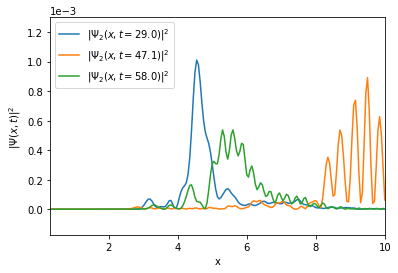

In [19]:
#stationary picture with time development for the report
stamps=np.array([0.4,.65,.8])
times=np.array(stamps*(tsteps-1),dtype=np.int)
fig, ax1 = plt.subplots()
# add psi^2 at different points in time
for i in range(len(times)):
    ax1.plot(x,np.abs(Psit2[times[i]])**2,label='$|\Psi_2(x,t=%.1f)|^2$'%(times[i]*dt/fs))
plt.ylim((-.02*1.3e-3/.15,1.3e-3))
plt.xlim(0.3,10)
plt.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('$|\Psi(x,t)|^2$')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
lines, labels = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,loc=1)
#plt.savefig('report/figures/withIR_2.eps')

Text(0, 0.5, '$|\\Psi(x,t)|^2$')

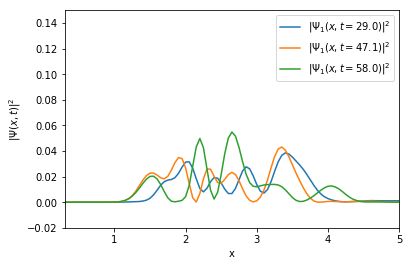

In [20]:
fig, ax1 = plt.subplots()
# add psi^2 at different points in time
for i in range(len(times)):
    ax1.plot(x,np.abs(Psit1[times[i]])**2,label='$|\Psi_1(x,t=%.1f)|^2$'%(times[i]*dt/fs))
plt.ylim(-.02,.15)
plt.xlim(0.3,5)
plt.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('$|\Psi(x,t)|^2$')
#plt.savefig('report/figures/withIR_1.eps')